In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os,sys
import scipy.integrate as spi

CURRENT_DIR = os.getcwd()
module_path = os.path.abspath(os.path.join(CURRENT_DIR, "../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
from Anydim_transferability.DeepSet.model import DeepSet
from Anydim_transferability.DeepSet import color_dict
from Anydim_transferability import typesetting
typesetting()

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


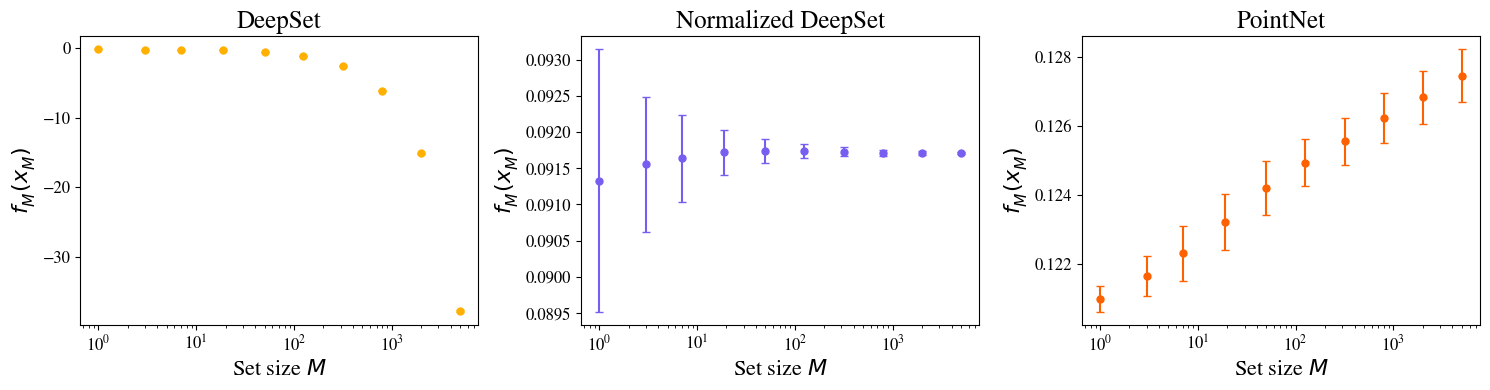

In [2]:
n_samples = 1000
log_n_range = np.arange(0.1, 4, 0.4)
torch.manual_seed(50)
# fix input distribution
gaussian = torch.distributions.Normal(loc=0.0, scale=1.0)

# fix 3 models with random weights
deepset = DeepSet(in_channels=1, output_channels=1, hidden_dim=128, normalization=None)
normalized_deepset = DeepSet(in_channels=1, output_channels=1, hidden_dim=128, normalization="mean")
pointnet = DeepSet(in_channels=1, output_channels=1, hidden_dim=128, normalization="max")
deepset.eval()
normalized_deepset.eval()
pointnet.eval()

# compute output
n_range = np.power(10, log_n_range).astype(int)
models = {
    "DeepSet": deepset,
    "Normalized DeepSet": normalized_deepset,
    "PointNet": pointnet,
}
outputs = {}
for model_name, model in models.items():
    outputs.setdefault(model_name, [])
    for i, n in enumerate(n_range):
        X = gaussian.sample((n_samples, n)).unsqueeze(-1)
        with torch.no_grad():
            output = model(X)
            outputs[model_name].append(output)

# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for ax, (model_name, color) in zip(axs, color_dict.items()):
    ax.errorbar(
        n_range,
        [float(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
        [float(outputs[model_name][i].std(dim=0).squeeze()) for i in range(len(n_range))],
        fmt="o",
        capsize=3,
        markersize=5,
        color=color,
    )
    ax.set_xscale("log")
    ax.set_xlabel(r"Set size $M$", fontsize=16)
    ax.set_ylabel(r"$f_M(x_M)$", fontsize=16)
    ax.set_title(model_name, fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=12)

plt.tight_layout()
plt.savefig(CURRENT_DIR + "/log/transferability/deepset_transferability_outputs.png")
plt.savefig(CURRENT_DIR + "/log/transferability/deepset_transferability_outputs.pdf")
plt.show()

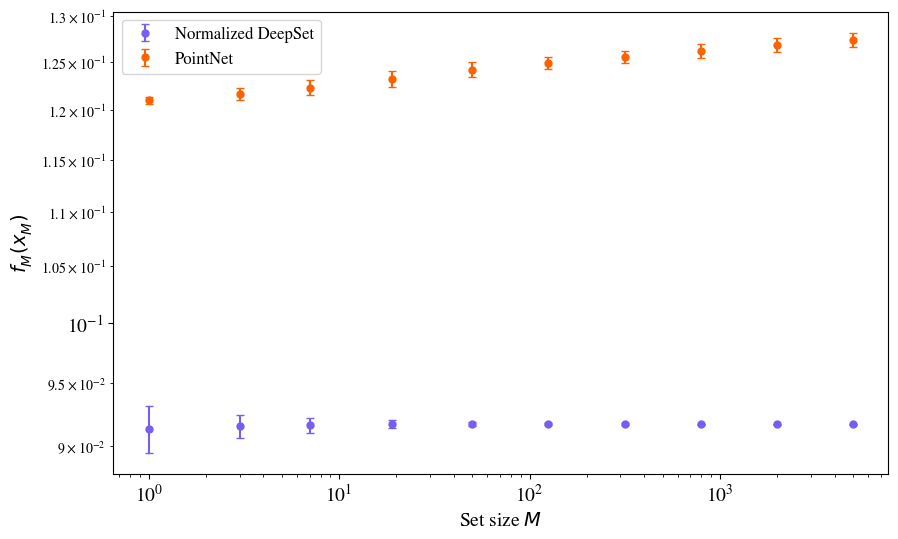

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))
models = [ "Normalized DeepSet", "PointNet"]
for model_name in models:
    ax.errorbar(
        n_range,
        [abs(outputs[model_name][i].mean(dim=0).squeeze()) for i in range(len(n_range))],
        [abs(outputs[model_name][i].std(dim=0).squeeze()) for i in range(len(n_range))],
        fmt="o",
        capsize=3,
        markersize=5,
        color=color_dict[model_name],
        label=model_name,
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Set size $M$", fontsize=14)
ax.set_ylabel("$f_M(x_M)$", fontsize=14)
ax.legend(fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=14)
plt.show()

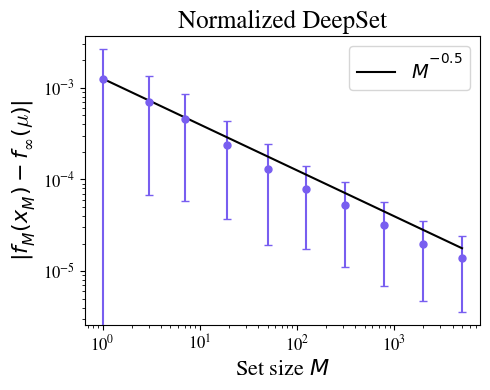

In [4]:
import numpy as np
import scipy.integrate as spi
import torch
import matplotlib.pyplot as plt


def gaussian_integral(model, a=-10, b=10, n=1000):
    x = np.linspace(a, b, n)
    with torch.no_grad():
        output = model.feature_extractor(torch.Tensor(x).reshape(-1, 1, 1)).squeeze().numpy()
    pdf = (np.exp(-(x**2) / 2) / np.sqrt(2 * np.pi)).reshape(-1, 1)
    y = output * pdf
    return spi.trapezoid(y, x, axis=0)


limit = float(
    normalized_deepset.regressor(
        torch.Tensor(gaussian_integral(normalized_deepset)).reshape(1, 1, -1)
    )
)

errors = [torch.abs(outputs["Normalized DeepSet"][i] - limit) for i in range(len(n_range))]
plt.figure(figsize=(5, 4))
plt.errorbar(
    n_range,
    [float(errors[i].mean(dim=0).squeeze()) for i in range(len(n_range))],
    [float(errors[i].std(dim=0).squeeze()) for i in range(len(n_range))],
    fmt="o",
    capsize=3,
    markersize=5,
    color=color_dict["Normalized DeepSet"],
)
reference = n_range ** (-0.5) * n_range[0] ** (0.5) * float(errors[0].mean(dim=0).squeeze())
plt.title("Normalized DeepSet", fontsize=18)
plt.plot(n_range, reference, label="$M^{-0.5}$", color="black")
plt.xlabel("Set size $M$", fontsize=16)
plt.ylabel("$|f_M(x_M) - f_\\infty(\\mu)|$", fontsize=16)
plt.legend(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(CURRENT_DIR + "/log/transferability/deepset_transferability_errors.png")
plt.savefig(CURRENT_DIR + "/log/transferability/deepset_transferability_errors.pdf")
plt.show()